In [1]:
import pandas as pd
import janitor
import gc
from utilities.utils import get_fulldata
from utilities.graph_utils import conbarplot
from utilities.graph_utils import save_mpl_fig
from utilities.graph_utils import pandas_to_tex
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid')
import warnings
warnings.filterwarnings('ignore')

FP_GENDER = '../data/hindi_eng_names_gender.csv.gz'

usecols = ['account_no', 'name_of_ryot', '6', '7', '8']
df = (get_fulldata(**{'usecols':usecols})
      # Compute land area (in acres)
      .assign(tt_area_acre=lambda df: df['6']+df['7']/100+df['8']*2.4711)
      .remove_columns(['6', '7', '8'])
      # Get religion via hindi names
      .merge((pd.read_csv(FP_GENDER, usecols=['name', 'pred_gender'])
              .rename_column('name', 'name_of_ryot')
              .rename_column('pred_gender', 'gender')
             ), how='left', on='name_of_ryot', validate='m:1'
            )
      .dropna(subset='gender')
      .query("tt_area_acre>0")
#       .assign(gender=lambda df: df.gender.str.capitalize())
     )
df.shape

(37413766, 4)

In [2]:
df.head(3)

,name_of_ryot,account_no,tt_area_acre,gender
0,मुसमात देवकी ओझा,701010001000008,8.525,female
1,म.तजमुल हुसैन,701010001000003,0.560,male
5,बेधानन्द झा,701010001000014,0.320,male


### Summary numbers

In [3]:
# Land plots are owned by woman
n_land_woman = len(df.query("gender=='female'"))
perc_land_woman = 100*n_land_woman/len(df)

print(f"{n_land_woman:,.0f} ({perc_land_woman:.1f}%) land plots are owned by woman")

8,342,419 (22.3%) land plots are owned by woman


In [4]:
df_num_plots = (df
                .groupby(["account_no", 'gender'])
                .size()
                .reset_index()
                .rename_column(0, 'nplots')
               )
df_num_plots.head(3)

,account_no,gender,nplots
0,101010273000001,female,2
1,101010273000002,male,8
2,101010273000003,male,1


In [5]:
n_accounts_woman = len(df_num_plots.query("gender=='female'"))
perc_accounts_woman = 100*n_accounts_woman/len(df_num_plots)

print(f"{n_accounts_woman:,.0f} ({perc_accounts_woman:.1f}%) accounts are under woman")

2,957,037 (25.9%) accounts are under woman


### Number of plots per account, by gender

In [6]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_nplot_perc_men = (df_num_plots
                      .query("gender=='male'")
                      .nplots.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('nplots', 'nplots_men')
                      .astype({"nplots_men":int})
                     )
tab_nplot_perc_women = (df_num_plots
                      .query("gender=='female'")
                      .nplots.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('nplots', 'nplots_women')
                      .astype({"nplots_women":int})
                     )
tab_nplot_perc = (tab_nplot_perc_women
                  .merge(tab_nplot_perc_men, 
                         on="Percentile", 
                         how="left", 
                         validate="1:1"
                        )
                  .assign(
                      nplots_women=lambda df: df.nplots_women.map('{:,.0f}'.format),
                      nplots_men=lambda df: df.nplots_men.map('{:,.0f}'.format)
                  )
                 )
pandas_to_tex(tab_nplot_perc, "../tables/percentiles_landplots_per_accountholder_gender")
tab_nplot_perc

,Percentile,nplots_women,nplots_men
0,0.00,1,1
1,0.10,1,1
2,0.20,1,1
3,0.30,1,1
4,0.40,1,1
5,0.50,1,1
6,0.60,1,2
7,0.70,2,2
8,0.80,3,4
9,0.90,6,7


In [7]:
# Prep graph options (fold cell)
# palette = ['indigo', 'gold'] # gender (and ethnic?) neutral
palette = "cividis" # gender (and ethnic?) neutral
# cmap = cm.get_cmap('viridis', 2)
# palette = []
# for i in range(cmap.N):
#     rgba = cmap(i)
#     palette.append(mpl.colors.rgb2hex(rgba))
legend_opts = {"title":"", 
               "loc":'best', 
               "labels":["Female", "Male"], 
               "frameon":False, 
               "fontsize":13, 
               "handletextpad":0.3
              }
cutoff = 0.95  # percentile to trim at 

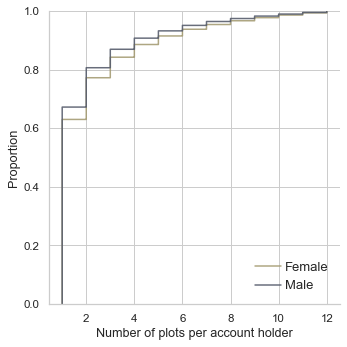

In [8]:
# Empirical CDF of #plots owned per account (fold cell)
sns.displot(x="nplots", 
            data=df_num_plots.query(f"nplots<={df_num_plots.nplots.quantile(cutoff)}"), 
            hue="gender",
            palette=palette,
            alpha=0.9,
            kind="ecdf",
            legend=False
           )
plt.xlabel("Number of plots per account holder")
plt.legend(**legend_opts)
save_mpl_fig('../figures/number_plots_per_accountholder_ecdf_gender')

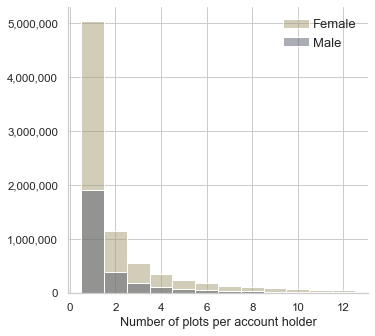

In [9]:
# Histogram of #plots owned per account (fold cell)
ax = sns.displot(data=df_num_plots.query(f"nplots<={df_num_plots.nplots.quantile(cutoff)}"), 
                 x="nplots", 
                 hue="gender",
                 palette=palette,
                 alpha=0.5,
                 kind='hist',
                 discrete=True,
                 legend=False
                )
ax.set_xlabels("Number of plots per account holder")
ax.set_ylabels("")
# https://stackoverflow.com/questions/39376888/how-to-separate-thousands-with-commas-using-facet-grid-in-seaborn
for _ax in ax.axes[:,0]:
    _ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(**legend_opts)    
save_mpl_fig('../figures/number_plots_per_accountholder_histogram_gender')    

### Land area per account, by gender

In [10]:
df_landarea = (df
               .groupby(["account_no", 'gender'])["tt_area_acre"]
               .sum()
               .reset_index()
              )
df_landarea.head(3)

,account_no,gender,tt_area_acre
0,101010273000001,female,0.585
1,101010273000002,male,1.545
2,101010273000003,male,0.080


In [11]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_area_perc_men = (df_landarea
                      .query("gender=='male'")
                      .tt_area_acre.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('tt_area_acre', 'area_men')
                     )
tab_area_perc_women = (df_landarea
                      .query("gender=='female'")
                      .tt_area_acre.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('tt_area_acre', 'area_women')
                     )
tab_area_perc = (tab_area_perc_women
                 .merge(tab_area_perc_men, 
                        on="Percentile", 
                        how="left", 
                        validate="1:1"
                       )
                  .assign(
                      area_women=lambda df: df.area_women.map('{:,.2f}'.format),
                      area_men=lambda df: df.area_men.map('{:,.2f}'.format)
                  )                 
                )
pandas_to_tex(tab_area_perc, "../tables/percentiles_landarea_per_accountholder_gender")
tab_area_perc

,Percentile,area_women,area_men
0,0.00,0.00,0.00
1,0.10,0.03,0.04
2,0.20,0.06,0.08
3,0.30,0.11,0.15
4,0.40,0.18,0.24
5,0.50,0.28,0.36
6,0.60,0.43,0.55
7,0.70,0.66,0.85
8,0.80,1.09,1.41
9,0.90,2.27,2.92


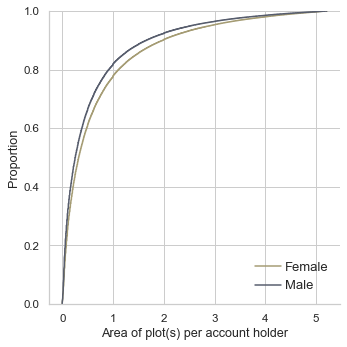

In [12]:
# Empirical CDF of land plot area owned per account (fold cell)
sns.displot(x="tt_area_acre", 
            data=df_landarea.query(f"tt_area_acre<={df_landarea.tt_area_acre.quantile(cutoff)}"), 
            hue="gender",
            palette=palette,
            kind="ecdf",
            legend=False
           )
plt.xlabel("Area of plot(s) per account holder")
plt.legend(**legend_opts)
save_mpl_fig('../figures/plot_area_per_accountholder_ecdf_gender')    

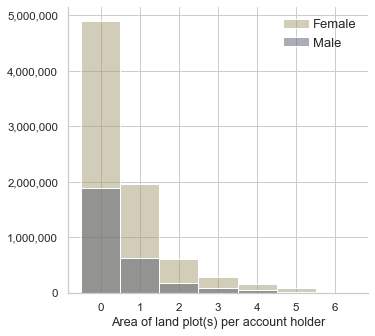

In [13]:
# Histogram of land plot area owned per account (fold cell)
ax = sns.displot(data=df_landarea.query(f"tt_area_acre<={df_landarea.tt_area_acre.quantile(cutoff)}"), 
                 x="tt_area_acre", 
                 hue="gender",
                 palette=palette,
                 kind='hist',
                 discrete=True,
                 color=".3",
                 legend=False
                )
ax.set_xlabels("Area of land plot(s) per account holder")
ax.set_ylabels("")
# https://stackoverflow.com/questions/39376888/how-to-separate-thousands-with-commas-using-facet-grid-in-seaborn
for _ax in ax.axes[:,0]:
    _ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(**legend_opts)
save_mpl_fig('../figures/plot_area_per_accountholder_histogram_gender')        

### Land area per account, by gender

In [14]:
nplots_by_account = (df
                     .groupby(['account_no', 'gender']).size().reset_index()
                     .rename_column(0, 'nplots')
                    )
landarea_by_account = (df
                       .groupby(['account_no', 'gender'])
                       .sum().reset_index()
                      )


df_land_per_plot = (landarea_by_account
                    .merge(nplots_by_account, 
                           how="left", on=["account_no", "gender"], validate="1:1")
                    .assign(land_per_plot=lambda df: df.tt_area_acre/df.nplots)
                   )
df_land_per_plot.head(3)

,account_no,gender,tt_area_acre,nplots,land_per_plot
0,101010273000001,female,0.585,2,0.292500
1,101010273000002,male,1.545,8,0.193125
2,101010273000003,male,0.080,1,0.080000


In [15]:
# Get table of percentiles (fold cell)
ntiles = [.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.96,.97,.98,.99,1]
tab_area_perc_men = (df_land_per_plot
                      .query("gender=='male'")
                      .land_per_plot.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('land_per_plot', 'area_men')
                     )
tab_area_perc_women = (df_land_per_plot
                      .query("gender=='female'")
                      .land_per_plot.quantile(ntiles)
                      .reset_index()
                      .rename_column('index', 'Percentile')
                      .rename_column('land_per_plot', 'area_women')
                     )
tab_area_perc = (tab_area_perc_women
                 .merge(tab_area_perc_men, 
                        on="Percentile", 
                        how="left", 
                        validate="1:1"
                       )
                 .assign(
                     area_women=lambda df: df.area_women.map('{:,.2f}'.format),
                     area_men=lambda df: df.area_men.map('{:,.2f}'.format)
                 )   
                )
pandas_to_tex(tab_area_perc, "../tables/percentiles_landarea_per_plot_per_accountholder_gender")
tab_area_perc

,Percentile,area_women,area_men
0,0.00,0.00,0.00
1,0.10,0.03,0.04
2,0.20,0.05,0.07
3,0.30,0.08,0.10
4,0.40,0.12,0.14
5,0.50,0.17,0.20
6,0.60,0.23,0.27
7,0.70,0.33,0.38
8,0.80,0.51,0.57
9,0.90,0.96,1.04


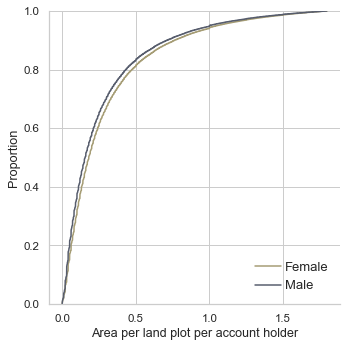

In [16]:
# Empirical CDF of land plot area owned per account (fold cell)
sns.displot(x="land_per_plot", 
            data=df_land_per_plot.query(f"land_per_plot<={df_land_per_plot.land_per_plot.quantile(cutoff)}"), 
            hue="gender",
            palette=palette,
            kind="ecdf",
            legend=False
           )
plt.xlabel("Area per land plot per account holder")
plt.locator_params(axis="x", nbins=5)
plt.legend(**legend_opts)
save_mpl_fig('../figures/landarea_per_plot_per_accountholder_ecdf_gender')    

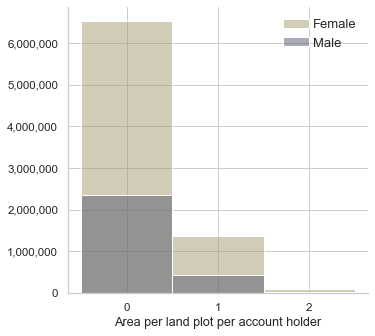

In [17]:
# Histogram of land plot area owned per account (fold cell)
ax = sns.displot(data=df_land_per_plot.query(f"land_per_plot<={df_land_per_plot.land_per_plot.quantile(cutoff)}"), 
                 x="land_per_plot", 
                 hue="gender",
                 palette=palette,
                 kind='hist',
                 discrete=True,
                 color=".3",
                 legend=False
                )
plt.xlabel("Area per land plot per account holder")
ax.set_ylabels("")
plt.locator_params(axis="x", nbins=6)
# https://stackoverflow.com/questions/39376888/how-to-separate-thousands-with-commas-using-facet-grid-in-seaborn
for _ax in ax.axes[:,0]:
    _ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(**legend_opts)
save_mpl_fig('../figures/landarea_per_plot_per_accountholder_histogram_gender')        

In [18]:
# import winsound
# frequency = 500  # Set Frequency To 2500 Hertz
# duration = 3000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)